# Finding Dory
## Politecnico di Milano, Internet of Things + Wireless Internet project
### Processing and localization

In the fist part of this project we have collected from the CoAP and MQTT server a total of 180 fingerprints and Dory's RSSI. In this part of the project we analyze the data and localize Dory using fingerprint-based methods.


# Import data

The fist step is importing the retrieved data and set it up in a format suitable for analysis. In this section we import the data by parsing with simple custom parsers the hand-crafted text files and convert the entire dataset into a standard dataframe, suitable for further analysis.

In [202]:
import ast
import pandas as pd
import numpy as np
from numpy.ma.core import log10

## Import data from CoAP

In [203]:
data_coap = []
with open("coap/coap_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("||")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integer literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(ast.literal_eval , ast.literal_eval(anchor_readings.strip()))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:]
      for anchor_idx in range(len(anchors_readings)):

        row.append(anchors_readings[anchor_idx][exp_idx])
      data_coap.append(row)
  
  # build df
  df_coap = pd.DataFrame(data=data_coap, columns=["X", "Y", "A1", "A2", "A3", "A4", "A5", "A6"])

## Import data from MQTT

In [204]:
data_mqtt = []
with open("mqtt/mqtt_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("|")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integet literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(int , anchor_readings.strip().split(","))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:]
      for anchor_idx in range(len(anchors_readings)):
        #print(anchors_readings[anchor_idx])
        row.append(anchors_readings[anchor_idx][exp_idx])
      data_mqtt.append(row)
  
  # build df
  df_mqtt = pd.DataFrame(data=data_mqtt, columns=["X", "Y", "A1", "A2", "A3", "A4", "A5", "A6"])

## Merging the two data sets plus Dory's RSSI

In [205]:
df = pd.concat([df_coap, df_mqtt])

# manually define Dory's RSSI
Dory_RSSI = [-57,-63,-58,-64,-63,-66]
Dory_RSSI_np = np.array(Dory_RSSI)
Dory_RSSI_mw = np.power(10, Dory_RSSI_np/10)

# dataset constraints to check if the data is valid
assert(len(df) == 6*6*5)
assert(df.isna().sum().sum() == 0)

display(df)

,X,Y,A1,A2,A3,A4,A5,A6
0,10,6,-64,-64,-61,-59,-59,-55
1,10,6,-60,-60,-57,-55,-55,-51
2,10,6,-62,-61,-58,-56,-57,-53
3,10,6,-66,-66,-63,-61,-61,-57
4,10,6,-64,-64,-61,-59,-59,-55
...,...,...,...,...,...,...,...,...
65,8,4,-59,-61,-54,-55,-57,-56
66,8,4,-66,-67,-61,-60,-63,-63
67,8,4,-64,-65,-59,-58,-61,-61
68,8,4,-65,-66,-60,-59,-62,-62


In [206]:
np.array(log10(Dory_RSSI_mw)*10)

array([-57., -63., -58., -64., -63., -66.])

## Aggregating data and dealing with missing values
Let us average all readings for an anchor at a position and build a dataframe of mean readings.

In [207]:
means_data = []
for x in range(0,11,2):
    for y in range(0,11,2):
      row = [x,y]
      row += df.loc[(df['X'] == x) & (df['Y'] == y)].mean()[["A1", "A2","A3","A4","A5","A6"]].values.tolist()
      means_data.append(row)
df_means = pd.DataFrame(data=means_data, columns=['X', 'Y', "A1", "A2", "A3", "A4", "A5", "A6"])
display(df_means)

,X,Y,A1,A2,A3,A4,A5,A6
0,0,0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0,2,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0,4,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0,6,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0,8,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
5,0,10,-66.0,-23.6,-65.2,-67.0,-58.0,-64.0
6,2,0,-52.6,-66.6,-56.0,-65.0,-66.8,-68.6
7,2,2,-54.4,-63.2,-56.4,-62.6,-63.8,-66.2
8,2,4,-58.2,-61.2,-59.2,-64.2,-61.8,-65.2
9,2,6,-62.0,-59.2,-61.6,-65.6,-60.0,-64.8


### Interpolation
Let us now perform linear and bilinear interpolation as needed to fill in the missing values.

In [208]:
# row-based
df_interpolation = df_means.copy()
for x in range(1,10,2):
  for y in range(0,11,2):

    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['X'] == (x - 1)) |
                                       (df_interpolation['X'] == (x + 1))) &
                                       (df_interpolation['Y'] == y)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])


# column-based
for x in range(0,11,1):
  for y in range(1,10,1):

    if not df_interpolation.loc[(df_interpolation['X'] == x) &
                                (df_interpolation['Y'] == y)].empty:
      continue
    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['Y'] == (y - 1)) |
                                       (df_interpolation['Y'] == (y + 1))) &
                                       (df_interpolation['X'] == x)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])

display(df_interpolation)

,X,Y,A1,A2,A3,A4,A5,A6
0,0.0,0.0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0.0,2.0,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0.0,4.0,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0.0,6.0,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0.0,8.0,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
...,...,...,...,...,...,...,...,...
0,10.0,1.0,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5
0,10.0,3.0,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8
0,10.0,5.0,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0
0,10.0,7.0,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6


### Euclidean Distance
Now that we have managed average the values of repeated measurements and to approximate the missing ones, we can compute again the Euclidean distance of each fingerprint from the Dory RSSI sample.

In [209]:
def compute_euclidean_distance(row):
  return np.linalg.norm(Dory_RSSI_np - row[["A1", "A2", "A3", "A4", "A5", "A6"]])

def compute_euclidean_distance_mw(row):
  return np.linalg.norm(Dory_RSSI_mw - np.power(10, row[["A1", "A2", "A3", "A4", "A5", "A6"]] / 10))

First we compute the Euclidean distance from the dataset composed only by the measured samples:

In [210]:
df_means['Euclidean Distance'] = df_means.apply(compute_euclidean_distance, axis=1)
df_means['Euclidean Distance Milliwatt'] = df_means.apply(compute_euclidean_distance_mw, axis=1)

display(df_means.nsmallest(20, 'Euclidean Distance', 'all')
    .loc[:,df_means.columns!="Euclidean Distance Milliwatt"]
    .head(1)
)
display(df_means.nsmallest(20, 'Euclidean Distance Milliwatt', 'all')
    .loc[:,df_means.columns!="Euclidean Distance"]
    .head(1)
)

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance
8,2,4,-58.2,-61.2,-59.2,-64.2,-61.8,-65.2,2.87054


,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance Milliwatt
8,2,4,-58.2,-61.2,-59.2,-64.2,-61.8,-65.2,6.877754e-07


In [211]:
df_interpolation['Euclidean Distance'] = df_interpolation.apply(compute_euclidean_distance, axis=1)
df_interpolation['Euclidean Distance Milliwatt'] = df_interpolation.apply(compute_euclidean_distance_mw, axis=1)

display(df_interpolation.nsmallest(20, 'Euclidean Distance', 'all')
    .loc[:,df_interpolation.columns!="Euclidean Distance Milliwatt"]
    .head(1)
)
display(df_interpolation.nsmallest(20, 'Euclidean Distance Milliwatt', 'all')
    .loc[:,df_interpolation.columns!="Euclidean Distance"]
    .head(1)
)

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance
0,2.0,3.0,-56.3,-62.2,-57.8,-63.4,-62.8,-65.7,1.28841


,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance Milliwatt
0,2.0,3.0,-56.3,-62.2,-57.8,-63.4,-62.8,-65.7,3.768190e-07


And then we can do the same with the dataset which contains the interpolated values:

### K-Nearest Neighbors
We'll apply the typical machine learning division: 30% training, 70% testing.

In [219]:
# creating ground truth

# creating coordinates list
coords = []
df_gt = df_interpolation.copy()
for row in df_gt.itertuples():
  coords.append((row.X, row.Y))

# mapping coordinates to unique integers
coord_to_int = {coord: i for i, coord in enumerate(coords)}

# defining function to retrieve the coordinate associated to an integer
def get_coord(i):
  for coord in coord_to_int:
    if coord_to_int[coord] == i:
      return coord

# adding column with ground truth integer map to each row
df_gt['gt'] = df_gt.apply(lambda row: coord_to_int[(row.X, row.Y)], axis=1)
display(df_gt)

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance,Euclidean Distance Milliwatt,gt
0,0.0,0.0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8,31.264037,2.087301e-03,0
1,0.0,2.0,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4,6.412488,5.280474e-06,1
2,0.0,4.0,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0,3.984972,8.395608e-07,2
3,0.0,6.0,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4,9.734475,2.047717e-06,3
4,0.0,8.0,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0,16.211107,1.065299e-05,4
...,...,...,...,...,...,...,...,...,...,...,...
0,10.0,1.0,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5,27.941367,1.774379e-04,116
0,10.0,3.0,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8,14.204225,3.822887e-06,117
0,10.0,5.0,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0,13.418644,2.573924e-06,118
0,10.0,7.0,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6,17.738940,7.039196e-06,119


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


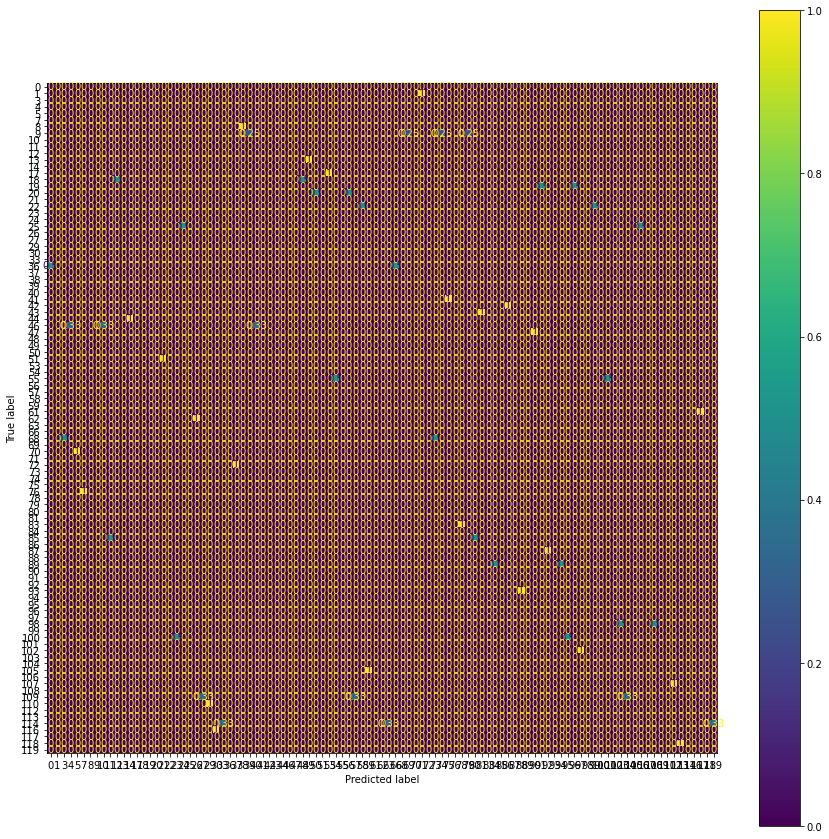

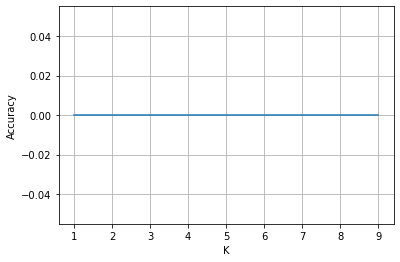

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

scaler = StandardScaler();

Y = df_gt['gt'];
X = df_gt.drop('gt',axis=1);

X_norm = scaler.fit_transform(X);

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)

ACCURACY = []
for k in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true');

fig = plt.figure();
plt.plot(range(1,10),ACCURACY);
plt.grid(visible=True);
plt.xlabel('K');
plt.ylabel('Accuracy');
